**Table of Contents**

* [Task I: Sentiment Analysis](#Task-I:-Sentiment-Analysis)
    * [Importing Libraries](#Importing-Libraries)
    * [Downloading NLTK Resources](#Downloading-NLTK-Resources)
    * [Loading the Data](#Loading-the-Data)
    * [Data Exploration](#Data-Exploration)
        * Distribution of Sentiments
        * Identifying Frequent Words
        * Review Length Analysis
    * [Text Preprocessing](#Text-Preprocessing)
        * Cleaning
        * Tokenization
        * Stop Word Removal
        * Lemmatization
    * [Feature Extraction](#Feature-Extraction)
        * TF-IDF Vectorization
    * [Model Training and Evaluation](#Model-Training-and-Evaluation)
        * Logistic Regression
        * Naive Bayes
        * Decision Tree
        * LSTM Model
        * Model Comparison
    * [Conclusions](#Conclusions)

* [Task II: Image Classification](#Task-II:-Image-Classification)
    * [Importing Libraries](#Importing-Libraries-1)
        * Pytorch
    * [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
        * Data Augmentation
        * Transforms
    * [Model Architecture](#Model-Architecture)
        * CNN
        * BatchNormalization
        * MaxPooling
        * Dropout
        * ReLU
    * [Training the Model](#Training-the-Model)
        * Confusion Matrix
    * [Evaluation](#Evaluation)
        * New Images

* [Sources](#Sources)

# Task I: Sentiment Analysis

In [1]:
# Importing Libraries

# Pandas and re for data loading and manipulataion
import pandas as pd
import re
# nltk for Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# sklearn for machine learning modeling and matrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# tensorflow.keras for neural network modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import Recall
from sklearn.naive_bayes import MultinomialNB # matplotlib for visulization
from sklearn.tree import DecisionTreeClassifier

# For displaying figures
import seaborn as sns
import matplotlib.pyplot as plt


In this section, we import the necessary libraries to support all steps in the workflow.

Preprocessing: pandas and sklearn assist in data cleaning, transforming raw text data, and preparing it for the next steps.

Vectorization: Tools like TfidfVectorizer are used to convert the text data into a numerical format, making it suitable for model training.

Model Training: scikit-learn or tensorflow, allow us to train and evaluate the model.

In [2]:
# Downloading NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# (Edward Loper, Steven, Bird, & Klein, 2024)

True

Downloading linguistic resources that are required for effective text normalization later on.


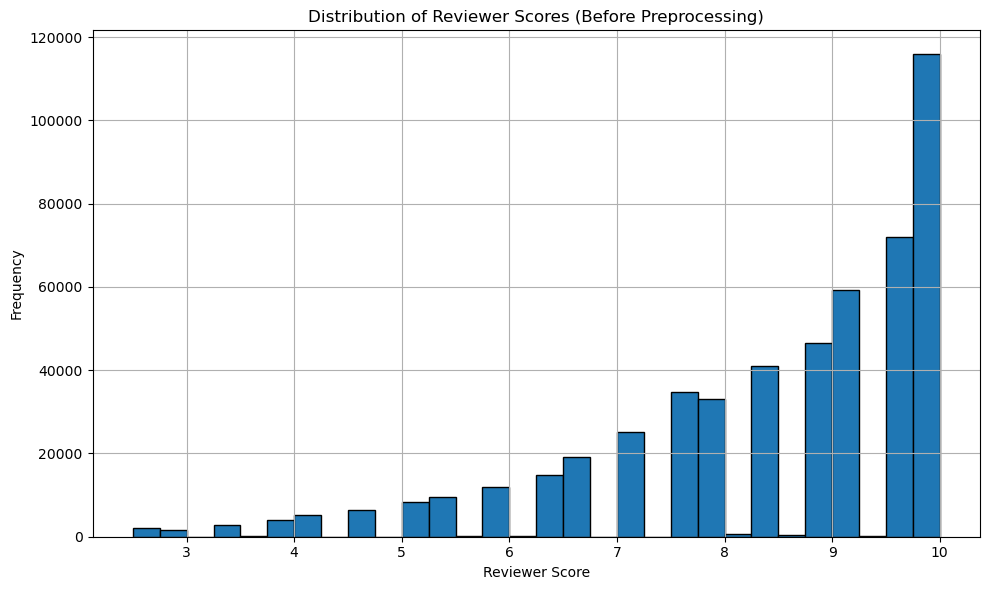

In [38]:
# Loading the dataframe before using it
df = pd.read_csv("Hotel_Reviews.csv")

# Visualizing the data
plt.figure(figsize=(10, 6))
df["Reviewer_Score"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Reviewer Scores (Before Preprocessing)")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# (Pandas Development Team, 2024), (Matplotlib Development Team, 2025)

This step helps us understand how user scores are distributed before any transformations, and we get insight to choose meaningful variables later on. E.g. most scores are above 8, which is important insight to difine "bad rewies" later on.

In [ ]:
# Load and combine reviews
df = pd.read_csv("Hotel_Reviews.csv")
df["Positive_Review"] = df["Positive_Review"].astype(str)
df["Negative_Review"] = df["Negative_Review"].astype(str)
df["reviews"] = df["Positive_Review"] + " " + df["Negative_Review"]

Combining both 'Positive_review' and 'Negative_review' perspectives into one sentence helps the model learn the overall sentiment of the user experience.

In [ ]:
# Example of a good and bad review, to justify the choise of value 8
# Filter for a good review (score > 8)
good_review_row = df[df["Reviewer_Score"] > 8].iloc[0]

# Filter for a bad review (score < 5)
bad_review_row = df[df["Reviewer_Score"] < 5].iloc[0]

# Display the reviews
print("\n=== Example of a Good Review (Score > 8) ===\n")
print(good_review_row["reviews"])

print("\n=== Example of a Bad Review (Score < 5) ===\n")
print(bad_review_row["reviews"])


=== Example of a Good Review (Score > 8) ===

 Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast   Apart from the price for the brekfast Everything very good

=== Example of a Bad Review (Score < 5) ===

 Only the park outside of the hotel was beautiful   I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the r

In [ ]:
# Analysis of reviews with a score under 8 and the information they contain

# Focus on reviews with Reviewer_Score <= 8
bad_reviews = df[df["Reviewer_Score"] <= 8]

# Count reviews where Negative_Review is not empty and not 'No Negative'
bad_with_negative_info = bad_reviews[~bad_reviews["Negative_Review"].str.lower().str.strip().isin(["no negative", ""])]

# Calculate percentage
total_bad_reviews = len(bad_reviews)
count_with_negative_info = len(bad_with_negative_info)
percent_with_negative_info = (count_with_negative_info / total_bad_reviews) * 100 if total_bad_reviews else 0

print("\n=== Analysis of what we have chosen as Bad Reviews (review score under 8) ===\n")
print(f"Total bad reviews (score <= 8): {total_bad_reviews}")
print(f"Bad reviews with real negative information: {count_with_negative_info}")
print(f"Percentage with negative information: {percent_with_negative_info:.2f}%")


=== Analysis of what we have chosen as Bad Reviews (review score under 8) ===

Total bad reviews (score <= 8): 180597
Bad reviews with real negative information: 167501
Percentage with negative information: 92.75%


The value 8 defines the threshold for negative reviews because it captures a wider range of critical feedback while maintaining class balance. Although the scale ranges from 0 to 10, most reviews are towards the higher end. Our analysis showed that 92% of reviews with score <= 8 contain real negative infrmation, which validates our choise.

In [ ]:
# Create label for bad reviews (score <= 8) before selecting specific columns
df["Bad_reviews"] = df["Reviewer_Score"].apply(lambda x: 1 if x <= 8 else 0)

We define binary labels in the `Bad_reviews' column, before selcting specific columns:
- 1 indicates a negativ experiense and happens when 'Reviewer_Score' is less or equal to 8
- 0 indictes a posetive experiense


The reason we define lables before selecting spesific colums is because at this point, we still have access to the original 'Reviewer_Score', which is necessary to generate the new label. If we had selected only the `reviwes' column too early, we would have lost the score and been unable to create our target label.




In [ ]:
# Select the desired columns
df = df[["reviews", "Bad_reviews"]]

We keep only the 'reviews' and the corresponding `Bad_reviews' label for our classification task. This ensures we focus solely on the textual content and sentiment label.


In [ ]:
# Basic cleanup: Remove placeholder texts, drop missing/duplicate entries
df["reviews"] = (
    df["reviews"]
    .str.replace("No Negative", "", regex=False)
    .str.replace("No Positive", "", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)
df.dropna(subset=["reviews"], inplace=True)
df.drop_duplicates(subset=["reviews"], inplace=True) #Removing duplicate reviews

This step removes placeholder text like "No Negative" and "No Positive", which appear in reviews where users did not express a negative or positive opinion. Since the placeholders don't carry any real sentiment or valubale information, removing it will reduce meaningless noise.

There may exist reviews with no text in the dataset so we drop missing values to ensure that we only train on actual content.Furthermore, we drop duplicates as it prevents the model from being biased by repeated information.

In [ ]:
# Show removed and kept stopwords
stop_words = set(stopwords.words("english"))
keep_words = {"not", "no", "never"}
filtered_stopwords = sorted(stop_words - keep_words)

print(f"Stopwords used (removed): {len(filtered_stopwords)}")
print(filtered_stopwords)

print("\nStopwords kept (NOT removed):")
print(sorted(keep_words))

Stopwords used (removed): 196
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan

In [ ]:
# Define cleaning function
def clean_text(text):
    keep_words = {"not", "no", "never"} # List of words we want to keep
    text = text.lower() # Lowercase all the text
    text = re.sub(r"[^a-z\s]", "", text) # Using regex to remove none-alphabetic symbols
    text = re.sub(r"\s{2,}", " ", text) # Using regex to replace every dobbel or more whitespace with one withspace
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english")) # Remove stopwords
    filtered_words = [w for w in words if (w not in stop_words) or (w in keep_words)]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return " ".join(lemmatized_words)

# (GeeksforGeeks, 2024)

First, we convert all text to lowercase to prevent the models from treating words like "Hotel" and "hotel" differently. We remove punctuation and non-alphabetic symbols, retaining only alphabetic characters. This may result in some information loss, in cases where reviews only contain symbols. A positive review like "<3" or ":)", will be lost.

We also correct any spacing issues that may have occurd during the earlier removal of palceholders, in order to standardize the text. This is important beacuse inconsistent spacing can introduce unnecassary variations that might affect the models ability to accurately interpret the input.

Then we remove stopwords, as they do not contributte meaningful sentiment information, but keep some words (keep_words) as these words can alter the sentiment when combined with other terms.

Lemmatization is then applied to reduce words to their base dictioary form ("running" becomes "run"), to reduce the dimensionality of the data, making the models more efficient. Word tokenization gives each word a value to prepare the text for further analysis.


In [ ]:
# Apply text cleaning to all reviews to generate a new column 'Reviews_clean'
df["Reviews_clean"] = df["reviews"].apply(clean_text)

This cleaned version will be used for all model training steps. We keep the original version for comparison and analysis.


In [ ]:
# Compute lengths of original and cleaned reviews
df["len_before"] = df["reviews"].str.split().str.len()
df["len_after"] = df["Reviews_clean"].str.split().str.len()

We create two columns to help us quantify the effect of preprocessing and ensures we didn't accidentally remove too much content.

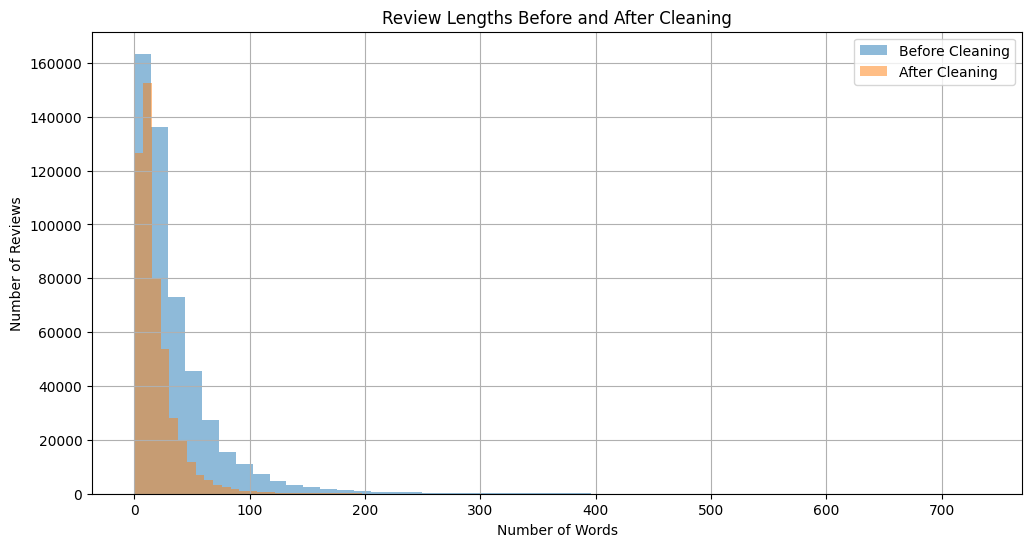

In [ ]:
# Plot histograms of review lengths
plt.figure(figsize=(12, 6))

# Called twice, once for each of the columns
plt.hist(df["len_before"], bins=50, alpha=0.5, label="Before Cleaning")
plt.hist(df["len_after"], bins=50, alpha=0.5, label="After Cleaning")

# Histogram layout
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Review Lengths Before and After Cleaning")
plt.legend()
plt.grid(True)
plt.show() # Display created histogram

# (The Matplotlib development team, 2025)

The plot shows the number of words before and after cleaning. This lets us see whether the cleaning drastically shortened the text and understand review length distribution.
We can use this information to choose padding lengths and detect outliers.

In [ ]:
# Final train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Bad_reviews"]
)

We split the dataset into training (80%) and testing (20%) sets using stratified sampling based on the `Bad_reviews' label. We use stratify as it ensures both train and test sets preserve the same class balance (positive/negative).

The reason for splitting the data now is to avoid any data leakage by ensuring that all preprocessing or model training happens only on the training set.


In [ ]:
# Display sample output
train_df.head()

,reviews,Bad_reviews,Reviews_clean,len_before,len_after
310980,Great rooms design breakfast,0,great room design breakfast,4,4
369391,Liked how quiet it was on the 6th floor Close...,0,liked quiet th floor close hard rock many good...,30,15
199145,Break fast is in Jamie s attached to the hote...,0,break fast jamie attached hotel could coffee m...,52,26
273513,central location the bed was Rock hard me and...,1,central location bed rock hard partner hardly ...,20,11
363641,This is a renovated hotel with tiny modern ro...,0,renovated hotel tiny modern room affordable pr...,63,37


In [ ]:
# Display information and statistics about training data
print("\nInformation about the training data:")
print(train_df.info())
print("\nDescriptive statistics of the training data:")
print(train_df.describe())


Information about the training data:
<class 'pandas.core.frame.DataFrame'>
Index: 398187 entries, 310980 to 442491
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   reviews        398187 non-null  object
 1   Bad_reviews    398187 non-null  int64 
 2   Reviews_clean  398187 non-null  object
 3   len_before     398187 non-null  int64 
 4   len_after      398187 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.2+ MB
None

Descriptive statistics of the training data:
         Bad_reviews     len_before      len_after
count  398187.000000  398187.000000  398187.000000
mean        0.353776      34.810237      19.244106
std         0.478141      38.825926      19.279757
min         0.000000       0.000000       0.000000
25%         0.000000      11.000000       7.000000
50%         0.000000      23.000000      14.000000
75%         1.000000      44.000000      24.000000
max         1.000000     733.00000

In [ ]:
# TF-IDF Vectorization with bigrams
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2)) # Creates a TF-IDF vectorizer object
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Reviews_clean"]) # Learns vocabulary and IDF weights from the training data, and converts the training data into a numerical matrix.
X_test_tfidf = tfidf_vectorizer.transform(test_df["Reviews_clean"])

`TfidfVectorizer' converts the cleaned review text into numerical feature vectors. Limiting the 'max-features' to 10000 to reduce memory issues and overfitting since this is a relatively large dataset and 10000 features allow capturing relevant patterns without excessive computation.
'ngram_range=(1, 2)' Includes both unigrams (single words) and bigrams (2-word combinations). Bigrams allow the model to learn important phrases like “not good” or “very clean”.



In [ ]:
# Store the binary target values ('Bad_reviews')
y_train = train_df["Bad_reviews"]
y_test = test_df["Bad_reviews"]

This step keeps inputs ('x') and labels ('y') seperate, which is standard practice for training and evaluation.



In [ ]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

We train a `LogisticRegression' model on the TF-IDF features.

The reason for choosing logistic regression as one of the models its because it’s a strong and interpretable baseline for binary classification. The model is fast to train, and handles high-dimensional text data well. And also works well when features are transformed with TF-IDF (Nirajan, 2023).

to ensure convergence we increase `max_iter=1000', as text models often require more iterations.


In [ ]:
# Defining a evaluate model to run after each machine learning models, except LSTM
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred)) # Accuracy
    print("Precision:", precision_score(y_test, y_pred)) # Precision
    print("Recall:", recall_score(y_test, y_pred)) # Recall
    print("Confusion Matrix:") # Show detailed breakdown of prediction results
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:") # Summarizes all key metrics
    print(classification_report(y_test, y_pred))

evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (TF-IDF)")

--- Logistic Regression (TF-IDF) Evaluation ---
Accuracy: 0.806342732578581
Precision: 0.7560152912075556
Recall: 0.6682568077916915
Confusion Matrix:
[[56735  7595]
 [11683 23534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85     64330
           1       0.76      0.67      0.71     35217

    accuracy                           0.81     99547
   macro avg       0.79      0.78      0.78     99547
weighted avg       0.80      0.81      0.80     99547



This function consistently evaluate our different models by computing:

*   Accuracy: Overall corecctness of predictions.
*  Precision: This is the most important to include because we want to minimize incorrect posetive predictions (false positives).
*   Recall: Measures how well the model captures actual posetive examples.
And confusion matrix and classification report.

In [ ]:
# Train and Evaluate Naive Bayes Model
nb_model = MultinomialNB() # Create model
nb_model.fit(X_train_tfidf, y_train) # Training the model
evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)") # Run evaluate function to visualize results

--- Naive Bayes (TF-IDF) Evaluation ---
Accuracy: 0.7920580228434809
Precision: 0.7377419671808981
Recall: 0.6395774767867791
Confusion Matrix:
[[56323  8007]
 [12693 22524]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.84     64330
           1       0.74      0.64      0.69     35217

    accuracy                           0.79     99547
   macro avg       0.78      0.76      0.76     99547
weighted avg       0.79      0.79      0.79     99547



We train a `MultinomialNB' model using the same TF-IDF features.

The reason for choosing a Naive Bayes Model is because its widely used for text classification tasks. It is also very fast and efficient for high-dimensional sparse data like TF-IDF, and often performs surprisingly well as a baseline (Ashafaque, 2023).

Evaluation helps us compare performance against Logistic Regression.




In [ ]:
# Train and Evaluate Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) # Max depth added
# Based on previous evaluation, deeper trees (e.g., 30) overfit and reduce recall significantly
dt_model.fit(X_train_tfidf, y_train)
evaluate_model(dt_model, X_test_tfidf, y_test, "Decision Tree (TF-IDF)") # Run evaluate function to visualize results

--- Decision Tree (TF-IDF) Evaluation ---
Accuracy: 0.7200819713301254
Precision: 0.6527212297465725
Recall: 0.44611977170116707
Confusion Matrix:
[[55971  8359]
 [19506 15711]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80     64330
           1       0.65      0.45      0.53     35217

    accuracy                           0.72     99547
   macro avg       0.70      0.66      0.67     99547
weighted avg       0.71      0.72      0.70     99547



Decision tree are greedy algoritms that handle sparse data well. At each step, they select the feature that best increases purit, recursively splitting the data and naturally ignoring less informative features.

Max depth was limited to 10 because deeper trees can overfit easily, especially with sparse, high-dimensional data. During tuning, deeper trees reduced recall, so this cap balances generalization and training time.

Decision trees also offer interpretability, though they often underperform compared to ensemble models on text (Spiering, 2021).


In [ ]:
# LSTM Model Training : sets parameters for LSTM model
max_vocab = 10000    # Setting the vocabulary size to max 10000
max_len = 100        # Padding/truncate reviews to 100 tokens
embedding_dim = 100  # Setting dimension to 100

# (Spectre, 2022)

Setting 'max_vocab' to 10000 limits the vocabulary to the 10000 most frequent words. By limiting the data, we reduce the computional complexity and memory requirements of the model, which helps prevent overfitting.

'max_len' is set to 100, so each review has 100 words or sub-words(tokens). This is because LSTM requires inout sequences of consistant lengths. Padding and trancuating ensures this.

Embedding is included for allowing the LSTM model to learn relationships between words and understand the context. A dimensionality of 100 provides a good balance between capturing the meaning and computional efficiency.

In [ ]:
# Tokenizer from Keras to convert text into integer sequences
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>") # 'num_words'=10000, only keep the 10000 most frequent words. Marks unknown words as <OOV>.
tokenizer.fit_on_texts(train_df["Reviews_clean"])             # Build word index from training reviews only.

We only keep the 10000 most frequent words to reduce the models complexity and improve efficency.
'oov_token' replace any unrecognised words during training with this token, preventing crashes from unseen test-time tokens.

We have to do these steps because Neural networks (like LSTMs) can't process raw text. They require fixed-length sequences of integers representing word indices.

In [ ]:
# Applies the tokenizer to both training and test sets

X_train_seq = tokenizer.texts_to_sequences(train_df["Reviews_clean"])   # Convert words to integer sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["Reviews_clean"])     # Apply same tokenizer to test data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # Pad/truncate to length 100
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# LSTM-model
model = Sequential([
    Embedding(10000, 100), # Input layer, 'max_vocab' and 'embedding_dim'
    LSTM(64), # LSTM units
    Dense(1, activation='sigmoid') # Otput layer. 1 is single output neuron
])
# Include 'recall' in the metrics list during model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall()]) # Compiling the model
model.build(input_shape=(None, 100)) # Building the model
model.summary() # Summarizing the model

# (Krishna-Noutiyal, 2025)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

We were required to include a neural network, and we chose LSTM. LSTMs are designed to capture sequential dependencies and retain information across time steps, making them highly effective for text-based tasks.

LSTM model suits this assignment better compered to other naural networks like Feedforward network. Feedforward treats input as independent features wich do not acount for word order('not good', 'good' needs order to understand the sentiment). Simple RNN could be an option, but suffers from the vanishing gradient problem, making it difficult to learn long-term dependencies (Calzone, 2022).

In [ ]:
# Train
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Predict
probs = model.predict(X_test_pad)
y_pred = (probs > 0.3).astype(int)

Epoch 1/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6541 - loss: 0.6403 - recall_6: 0.0962 - val_accuracy: 0.6491 - val_loss: 0.6060 - val_recall_6: 0.0149
Epoch 2/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7148 - loss: 0.5532 - recall_6: 0.5284 - val_accuracy: 0.8018 - val_loss: 0.4211 - val_recall_6: 0.6418
Epoch 3/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8061 - loss: 0.4123 - recall_6: 0.6683 - val_accuracy: 0.8064 - val_loss: 0.4119 - val_recall_6: 0.6662
Epoch 4/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.8175 - loss: 0.3927 - recall_6: 0.6854 - val_accuracy: 0.8057 - val_loss: 0.4142 - val_recall_6: 0.6887
Epoch 5/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8262 - loss: 0.3761 - recall_6: 0.6978 - val_accuracy: 0.8046 - val_loss: 0.4189 - val_recall_6: 0.6503
Epoch 6/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8342 - loss: 0.3622 - recall_6: 0.7128 - val_accuracy: 0.803

The code first trains the LSTM model on the training data and then applies it to predict the sentiment of new reviews, ultimately providing a classification (bad review or not) for each review in the test set.

*   epochs=10: Gives the model enough passes through the data to learn, but not too many to risk overfitting.
*   batch_size=128: Balances training speed and memory efficiency while providing stability and potentially better generalization.
*   validation_split=0.2: Sets aside a portion of the training data to monitor performance and prevent overfitting during training.


In [ ]:
# Evaluation Metrics for LSTM model

y_true = y_test #settint the True values

#calculating the evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display the results
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.7725
Precision: 0.6488
Recall: 0.7785
F1 Score: 0.7078

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     64330
           1       0.65      0.78      0.71     35217

    accuracy                           0.77     99547
   macro avg       0.76      0.77      0.76     99547
weighted avg       0.79      0.77      0.78     99547



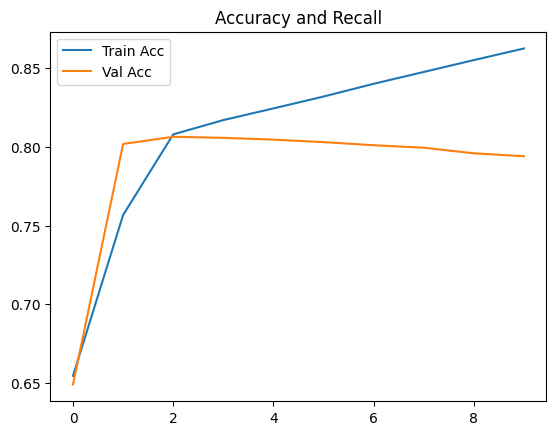

In [ ]:
# Plots to visualize accurcy and recall for LSTM model
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy and Recall')
plt.legend()
plt.show()

# (Yandle, 2021), (Raschka, 2023)

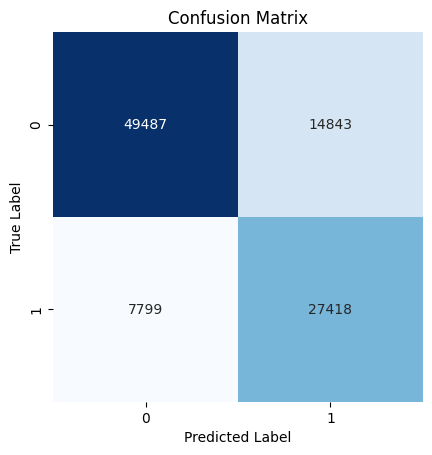

In [ ]:
# Heatmap to visulaze predictive positive and actual positiv for LSTM model
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# (Marsja, 2023)

Based on evaluation results:



*   Logistic Regression achived the best overall accuracy (0.81) and strong precision (0.76) and recall (0.67)
*   Naive Bayes had slightly lower accuracy (0.79), recall (0.64) and precision (0.74).
*   The Decison Tree performed the worst with the lowest accuracy (0.72), precision (0.65), and a low recall (0.45).
*   The LSTM model showed balanced performance with solid recall (0.78) although its precision(0.65) was lower than Logistic Regression.

We can conclud with that in this case Logistic Regression is the best for balanced performance, while LSTM may be preffered when recall is prioritized.


## Task II

## Libraries

We decided to use the the Pytorch framework because of its ease of use and beginner friendly development. Pytorch is also has comprehensive documentation making it easy to research what the framework offers. 

In [4]:
# PyTorch core library for tensors and deep learning
import torch

# Pandas for data loading and manipulation
import pandas as pd

# NumPy for numerical operations
import numpy as np

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# PIL for image processing (used to load and manipulate images)
from PIL import Image

# torchvision for pre-built datasets, models, and image transformations
import torchvision

# v2 transforms (newer API) for preprocessing and data augmentation
from torchvision.transforms import v2

# Core PyTorch neural network modules
import torch.nn as nn
import torch.nn.functional as F

# AdamW optimizer for training (variant of Adam with better regularization)
from torch.optim import AdamW

# Subset and DataLoader for dataset splitting and efficient batching
from torch.utils.data import Subset, DataLoader

# Dataset base class for creating custom datasets
from torch.utils.data import Dataset

# scikit-learn metrics for model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# PyTorch Lightning callbacks for early stopping and model saving
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# PyTorch Lightning Trainer for managing the training loop
from pytorch_lightning import Trainer

## Loading and pre-processing the data 

torchvision.datasets.CIFAR10 is a built-in class we use to load the data. This allows us to download the CIFAR-10 dataset directly into our project directory. We choose this because it makes it easy to manage both the training and test sets by simply setting the train parameter to True or False. When train=True, the class returns the training portion of the dataset, and when False, it loads the test set instead.

The dataset consists of five training batches, each containing 10,000 images. The test set includes exactly 1,000 randomly selected images from each class. The remaining images are shuffled randomly, but the distribution of classes may vary across batches. Altogether, the training sets provide exactly 5,000 images for each class.

We begin by defining a transform to preprocess the data, making it more suitable for the model.

The first transform we use to prepare the images is ToTensor(). ToTensor converts a PIL image into a torch.FloatTensor, which PyTorch models require. It also changes the image shape from (Height x Width x Channels) to (Channels x Height x Width) and normalizes pixel values from [0, 255] to [0.0, 1.0], making the data more suitable for the CNN.

Next, we apply the Normalize() transformation to rescale pixel values for each channel. The Normalize(mean, std) function standardizes each channel using the formula: Output = (input – mean) / std. We apply this after ToTensor so that each pixel value is between 0 and 1, with a new value of: New Value = (Old Value – 0.5) / 0.5.

By combining ToTensor() and Normalize() in a pipeline with the Compose class, we ensure the data is formatted and scaled correctly for PyTorch models.

In [ ]:
# Pytorch transform
transform = v2.Compose([
    # Convert to tensor 
    v2.ToTensor(),
    # Rescale image
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 traning set
training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Loading the CIFAR-10 traning set
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
# All 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# (PyTorch, 2024)

In [6]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

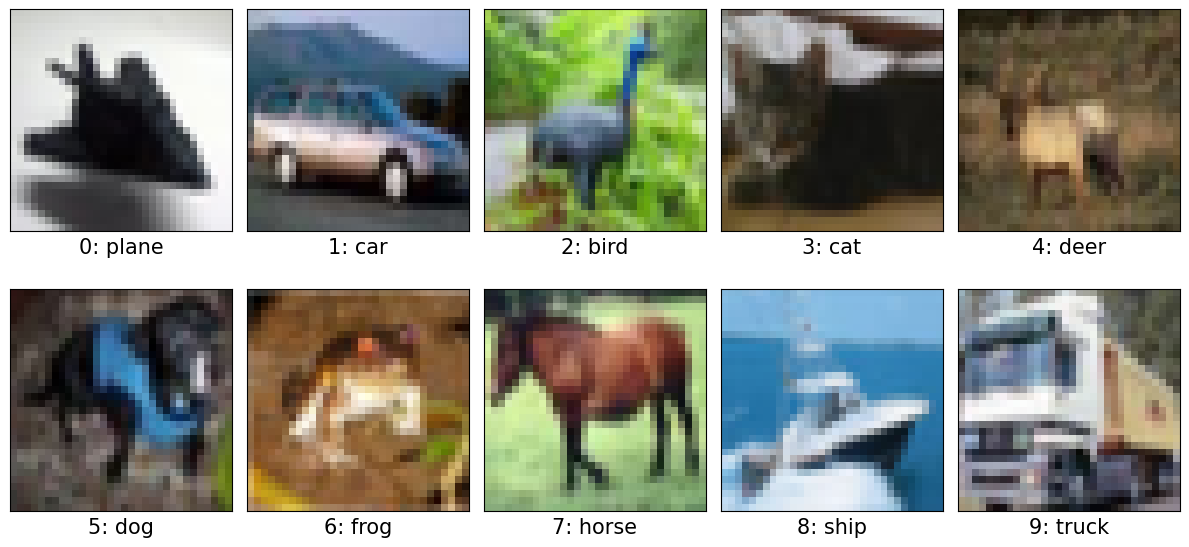

In [7]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))


for i, axis in enumerate(axes.flat):
    # Set labels: class number: Class
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    # Shows the corresponding image of the claass it represents
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])

# Plot out the images
plt.tight_layout()
plt.show()

# (Nekouei, 2023)

In [8]:
# Function for printing information about a given dataset
def print_stats(dataset, class_names):
    label_counts = {}

    # Checks if the dataset is a Subset object
    if isinstance(dataset, Subset):
        targets = dataset.dataset
        indices = dataset.indices
    else:
        targets = dataset
        indices = range(len(dataset))

    for i in indices:
        _, label = targets[i]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    # Prints out the label and how many images of the given label in the dataset
    print(f"Total images: {len(indices)}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")


In [9]:
# Print out traning and test data using print_stats
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


This FrogBinaryDataset class wraps around an existing dataset subset and transforms it into a binary classification task. The key functionality lies in the __getitem__ method, where each label is checked: if it equals 6 (frog), it's converted to 1; otherwise, it becomes 0. This simplifies a multi-class problem—the 10 classes in the dataset—into a binary classification problem: frog and non-frog.

In [10]:
# Class for truning a datase
class FrogBinaryDataset(Dataset):
    def __init__(self, dataset):
        # Data form dataset
        self.dataset = dataset

    # Function for getting a sample form the dataset
    def __getitem__(self, item):
        data, label = self.dataset[item]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label
    
    # Fucntion for getting the length of the dataset
    def __len__(self):
        return len(self.dataset)
    
# (Pytorch, 2024)

## Building the Training Dataset

We used a combination of the original dataset and 5,000 augmented frog images in our training set. This augmentation strategy enhanced data diversity, helping the model generalize better and improve performance. Augmented images allow the model to better recognize the frog class and generalize across variations. Augmentation also addresses common CNN issues like overfitting, poor generalization, and low accuracy (Hallaj, 2023).

A drawback of augmentation is increased computational cost and potential noise. However, we added too few images for this to be a significant concern.

In [11]:
# Transform for augmenting images
augmented_transform = v2.Compose([
    # Crops the image
    v2.RandomCrop(32, padding=4),
    # Flips the image
    v2.RandomHorizontalFlip(),
    # Change the brightness
    v2.ColorJitter(brightness=0.4, contrast=0.4),
    # Converts to tensor
    v2.ToTensor(),
    # Normalize a tensor image
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# (Torch Contributors, 2017)
# (Ruman, 2023)

In [12]:
# Loading in the dataset to be augmented
augmented_training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmented_transform)
# Gets all frog images from the dataset
frog_indices = [i for i, (_, label) in enumerate(augmented_training_data) if label == 6]

# Creates a subset object
augmented_frog_iamges = Subset(augmented_training_data, frog_indices)

In [13]:
# Function to unnormalize the image
def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # inverse of normalization for visualisation 

In [14]:
# Visulize the augmented dataset

# wrap in dataloader for easier use
loader = DataLoader(augmented_frog_iamges, batch_size=16, shuffle=True)
data_iter = iter(loader)
images, _ = next(data_iter)

# Unnormalize
images = unnormalize(images)

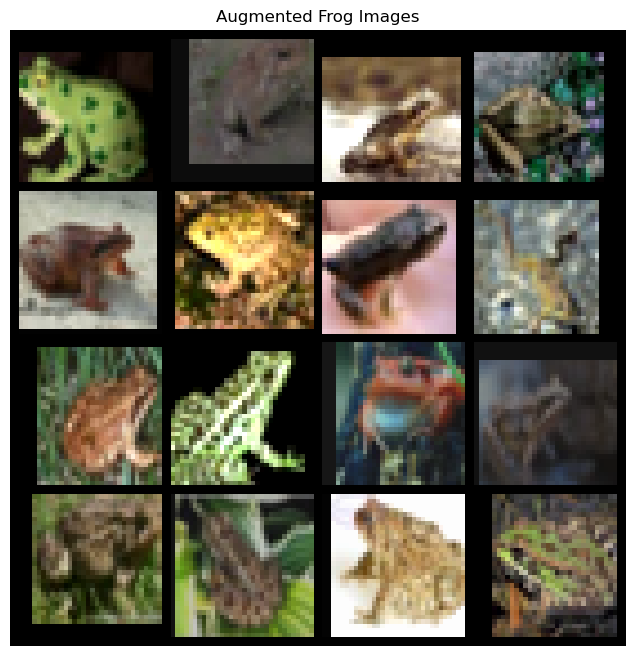

In [15]:
# Make a grid
img_grid = torchvision.utils.make_grid(images, nrow=4)

# Convert to numpy and show
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title('Augmented Frog Images')
plt.show()

In [16]:
# New traningdataset
complete_traningdata = training_data + augmented_frog_iamges

In [17]:
# Present the traning data
print("Traning data")
print_stats(complete_traningdata, classes)

Traning data
Total images: 55000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 10000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


In [18]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(complete_traningdata)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

In [19]:
# Calculate lengths for the split
total_size = len(test_data)
split_size = int(total_size // 2)

# Splitting the testset into equal parts test and validation
test_subset = Subset(test_data, range(split_size))
val_subset = Subset(test_data, range(split_size, total_size))


In [20]:
# Present the test and validation data
print("Testdata")
print_stats(test_subset, classes)
print("\n")
print("Validationdata")
print_stats(val_subset, classes)

Testdata
Total images: 5000
Label 0 (plane): 488
Label 1 (car): 505
Label 2 (bird): 512
Label 3 (cat): 497
Label 4 (deer): 507
Label 5 (dog): 488
Label 6 (frog): 491
Label 7 (horse): 495
Label 8 (ship): 504
Label 9 (truck): 513


Validationdata
Total images: 5000
Label 0 (plane): 512
Label 1 (car): 495
Label 2 (bird): 488
Label 3 (cat): 503
Label 4 (deer): 493
Label 5 (dog): 512
Label 6 (frog): 509
Label 7 (horse): 505
Label 8 (ship): 496
Label 9 (truck): 487


## Building the Test and Validation Dataset

To evaluate model performance, we split a 10,000-sample dataset evenly into test and validation sets, each containing 5,000 images. The split was done using index-based slicing without stratification, which may cause minor class imbalances.

This introduces a class imbalance that negatively affects performance. While the original balance is suitable for multi-class classification, it becomes problematic when the model must distinguish one class from nine others. This issue could have been addressed through resampling or by applying class weights during training.

Another approach would be to split the test and validation data into a 50/50 ratio of frog and non-frog classes. We decided not to use this method because we wanted our model to remain representative of the original CIFAR-10 dataset.

In [21]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_subset)
binary_validationset = FrogBinaryDataset(val_subset)

In [22]:
# Wrap in DataLoaders
testloader = DataLoader(binary_testset, batch_size=64, shuffle=True)
valoader = DataLoader(binary_validationset, batch_size=64, shuffle=True)

## Convolutional Neural Network 

We created our own convolutional neural network (CNN) called “FrogClassifier” to perform binary classification. The architecture begins with two convolutional layers, each utilizing a 5×5 kernel to extract spatial features from the input images. These layers are followed by batch normalization, ReLU activation, and max pooling to improve training efficiency and preserve key visual features such as edges and textures.

The output from the convolutional blocks is flattened and passed through three fully connected layers with dropout and batch normalization to reduce overfitting and improve stability. The final output layer returns two logits for the binary classification task (frog or not-frog).

We use batch normalization to stabilize training and enable faster convergence (Piyush Kashyap, 2024), and max pooling to preserve spatial features—supported by Zhao and Zhang (2024), who showed it outperforms average pooling on CIFAR datasets. We use dropout to randomly deactivate neurons, reducing overfitting, and ReLU activation to introduce nonlinearity by converting negative values to zero (Krishnamurthy, 2024).

Lastly, we implement a forward function to define the sequence in which data flows through the model, applying each step—ReLU, dropout, and pooling—in order to produce the final output.

In [23]:
# Class defining the convolutional neural network
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolutional layer: input has 3 channels (RGB), output has 12 filters
        # Each filter has a kernel size of 5x5
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        # Batch normalization to stabilize and accelerate training after the first conv layer
        self.bn1 = nn.BatchNorm2d(12)
        
        # Max pooling layer to reduce spatial dimensions (downsampling)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer: input has 12 channels, output has 24 filters
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5)
        
        # Batch normalization after the second conv layer
        self.bn2 = nn.BatchNorm2d(24)
        
        # First fully connected (dense) layer: input is flattened from conv output (24 * 5 * 5)
        # Output is 120 features
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.3)  # Dropout to reduce overfitting
        
        # Second fully connected layer: 120 inputs to 84 outputs
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.3)
        
        # Final fully connected layer: output 2 values (binary classification: frog or not)
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        # Apply first convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        
        # Apply second convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        # Flatten the output for the fully connected layers
        data = torch.flatten(data, 1)
        
        # First dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        # Second dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        # Final output layer (logits for 2 classes)
        data = self.fully_connected3(data)
        
        return data

# (Ingole, 2024)

## Adam and optimizer 

To start training the “FrogClassifier” model, we use CrossEntropyLoss as the loss function and AdamW as the optimizer. AdamW decouples weight decay from the gradient update, leading to better generalization and training stability (Contributors, 2025).

AdamW improves regularization behavior without affecting the optimizer’s internal moments. This is beneficial in convolutional networks, where overfitting is often a concern.

In [24]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()

# Using cross entropy loss
loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(neural_network.parameters(), lr=0.001, weight_decay=0.01)

# (PyTorch Contributors, 2024)

In [ ]:
# Defining the earlystopping class
early_stop_callback = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.00, patience=3, 
    verbose=False, mode="max")

# Defining a the checkpoint class
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-model"
)

# Apply the early stop on the traning
trainer = Trainer(callbacks=[early_stop_callback])

# (Lightning.ai, 2024)

## Training the Model 

The “EarlyStopping” callback monitors accuracy (val_accuracy) and stops training if it doesn’t improve after 3 consecutive epochs. We chose 3 because it's long enough to detect improvements, but also short enough to prevent wasting resources. By setting “mode=max”, the callback looks for the highest possible accuracy, which prevents unnecessary training once the model has plateaued, saving time and reducing the risk of overfitting.

We also use “ModelCheckpoint” to automatically save the best-performing model during training. It monitors the validation loss and keeps the model with the lowest loss. This ensures the most generalizable version of the model, even if later epochs result in overfitting.

In [26]:
# List for tracking the traning loss
list_of_train_loss = []
# List for tracking validation loss
list_of_val_loss = []
# Number of epochs to run
epochs = range(20)

# Nummber of epochs with worse loss before stopping
patience = 3
# Best val loss recorded
best_val_loss = float('inf')
# Epochs number
counter = 0

# Traning loop
for epoch in epochs:
    print(f"\nEpoch {epoch+1} / {max(epochs)}")
    
    # Training
    neural_network.train()
    # Current loss
    running_loss = 0.0
    
    # Iterating over the traning data
    for inputs, labels in trainloader:
        # Set optimizer
        optimizer.zero_grad()
        # Outputs returned from the model
        outputs = neural_network(inputs)
        # Compute loss 
        loss = loss_function(outputs, labels)
        loss.backward()
        # Perform a single optimization step
        optimizer.step()
        running_loss += loss.item()
    
    # Compute the avrage loss form traning
    avg_train_loss = running_loss / len(trainloader)
    # Add it to the list of traning loss
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    neural_network.eval()
    # Validation loss
    val_loss = 0.0
    # Correctly predicted
    correct = 0
    # Total predictions
    total = 0
    
    # Context-manager that disables gradient calculation 
    with torch.no_grad():
        # Iterate over batches in the validation dataset
        for val_inputs, val_labels in testloader:
            # Forward pass: compute model outputs for validation inputs
            outputs = neural_network(val_inputs)
            # Compute loss between outputs and true labels
            loss = loss_function(outputs, val_labels)
            # Accumulate validation loss
            val_loss += loss.item()
            
            # Get the predicted class labels
            _, predicted = torch.max(outputs, 1)
            # Update total number of samples seen
            total += val_labels.size(0)
            # Update number of correctly predicted samples
            correct += (predicted == val_labels).sum().item()

    # Calculate average validation loss over all batches
    avg_val_loss = val_loss / len(testloader)
    # Append current validation loss to the history list
    list_of_val_loss.append(avg_val_loss)
    # Calculate validation accuracy
    val_acc = 100 * correct / total

    # Print validation metrics
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If current validation loss improves, update best loss and reset counter
        best_val_loss = avg_val_loss
        counter = 0
        # Save the current best model weights
        torch.save(neural_network.state_dict(), "best_model.pth")
    else:
        # If no improvement, increment the counter
        counter += 1
        print(f"No improvement in validation loss ({counter}/{patience})")
        # If no improvement for 'patience' consecutive checks, stop training
        if counter >= patience:
            print("Early stopping triggered.")
            break
        
# (Olu-Ipinlaye, 2024)
# (Koehrsen, 2018)


Epoch 1 / 19
Train Loss: 0.2222
Validation Loss: 0.1527 | Accuracy: 93.88%

Epoch 2 / 19
Train Loss: 0.1709
Validation Loss: 0.1663 | Accuracy: 93.68%
No improvement in validation loss (1/3)

Epoch 3 / 19
Train Loss: 0.1529
Validation Loss: 0.1472 | Accuracy: 94.44%

Epoch 4 / 19
Train Loss: 0.1447
Validation Loss: 0.1477 | Accuracy: 94.48%
No improvement in validation loss (1/3)

Epoch 5 / 19
Train Loss: 0.1321
Validation Loss: 0.1370 | Accuracy: 94.92%

Epoch 6 / 19
Train Loss: 0.1239
Validation Loss: 0.1375 | Accuracy: 95.20%
No improvement in validation loss (1/3)

Epoch 7 / 19
Train Loss: 0.1179
Validation Loss: 0.1397 | Accuracy: 95.14%
No improvement in validation loss (2/3)

Epoch 8 / 19
Train Loss: 0.1091
Validation Loss: 0.1294 | Accuracy: 95.42%

Epoch 9 / 19
Train Loss: 0.1044
Validation Loss: 0.1446 | Accuracy: 95.20%
No improvement in validation loss (1/3)

Epoch 10 / 19
Train Loss: 0.0976
Validation Loss: 0.1283 | Accuracy: 95.38%

Epoch 11 / 19
Train Loss: 0.0929
Valid

We found that our model is learning well during traning, given the steady decrease in training loss. However, our validation loss is relatively unstable but generally shows a downward trend. The varying validation results show some signs of overfitting, which can be attributed to the relatively small test set, making it difficult for the model to generalize. But this is mitigated using early stopping to enshure val loss doesn't get worse. We chose 20 epochs because the model typically stops between 5 and 12 epochs, providing enough room for training while allowing early stopping to take effect if needed. To summarize, the performance shows that the model is learning what a frog is but displays some signs of overfitting.

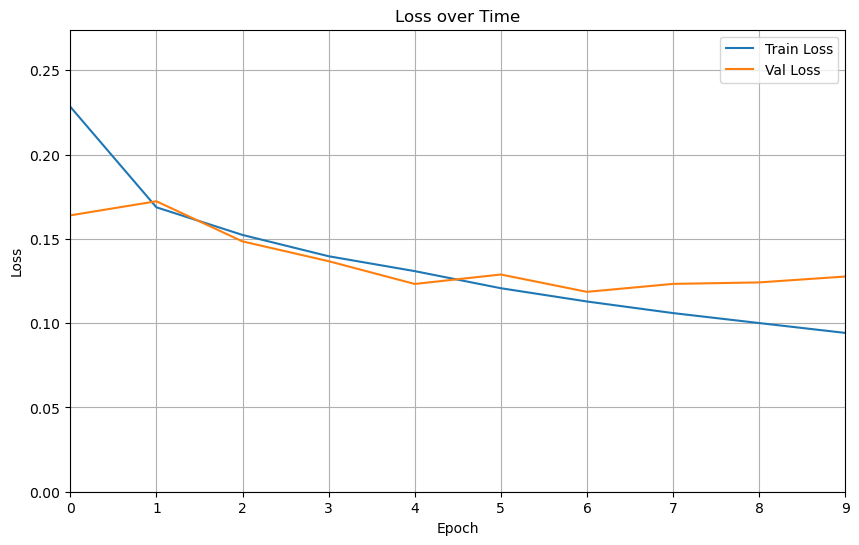

In [ ]:
# Plotting
epochs = range(len(list_of_train_loss))
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
# X axsis range between min and max epochs
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# (Hunter, 2025)

## Validation 


In [27]:
# Save the model
neural_network.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

## Evaluation

When evaluating the model, we use the validation dataset to assess the accuracy and reliability of the model’s predictions. This step is crucial because it provides an unbiased evaluation of how well the model is learning and generalizing to unseen data. By comparing the model’s predictions to the actual labels in the validation set, we gain insight into its performance, including potential issues like overfitting or underfitting. Ultimately, this helps us determine how well the model is performing.

In [28]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [29]:
# Evaluation loop

# Initialize metrics
# Correct predictions
correct = 0
# Total predictions
total = 0
# Running valuation loss
val_loss = 0.0

true_positive = 0
false_negative = 0

# List of all predictions
all_preds = []
# List of all labels
all_labels = []

# Run evaluation
with torch.no_grad():
    # Iterate over the validation loss 
    for val_inputs, val_labels in valoader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (assuming frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

# (Olu-Ipinlaye, 2024)

By using a confusion matrix, we get a visual representation of how well the model performs and which labels it struggles with. As a result, we see that our model is largely successful at correctly labeling both the non-frog and frog classes.

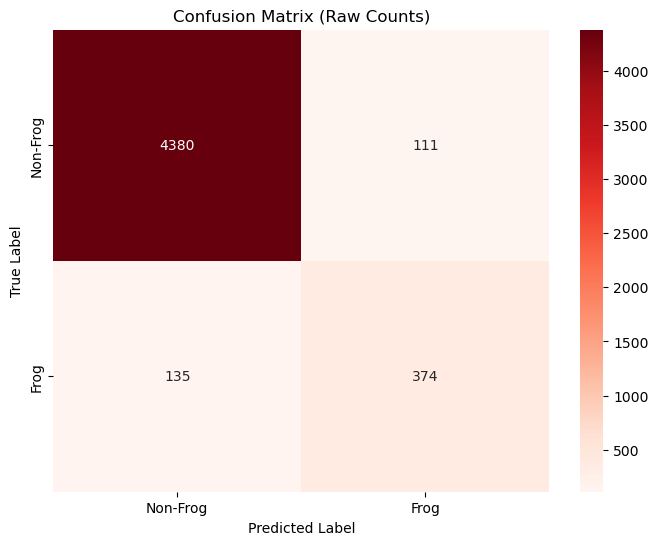


Classification Report:
              precision    recall  f1-score   support

    Non-frog       0.97      0.98      0.97      4491
        Frog       0.77      0.73      0.75       509

    accuracy                           0.95      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.95      0.95      0.95      5000



In [ ]:
# Confusion Matrix with raw counts
labels = ["Non-Frog", "Frog"]
confusion_matrix = confusion_matrix(all_labels, all_preds)

# Create DataFrame with raw counts
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

# Plot heatmap with counts
plt.figure(figsize=(8, 6))
sn.heatmap(df_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix (Raw Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-frog", "Frog"]))

# (scikit-learn developers, 2025)

## Prediction on New image

When presenting the model with new images, we need to augment them to make them similar to the CIFAR-10 dataset. Since the images we are taking in don’t suit our model, we are transforming them. The transformation ensures a consistent input shape for the model and improves convergence speed and stability during training, similar to what we did in Task IIa.

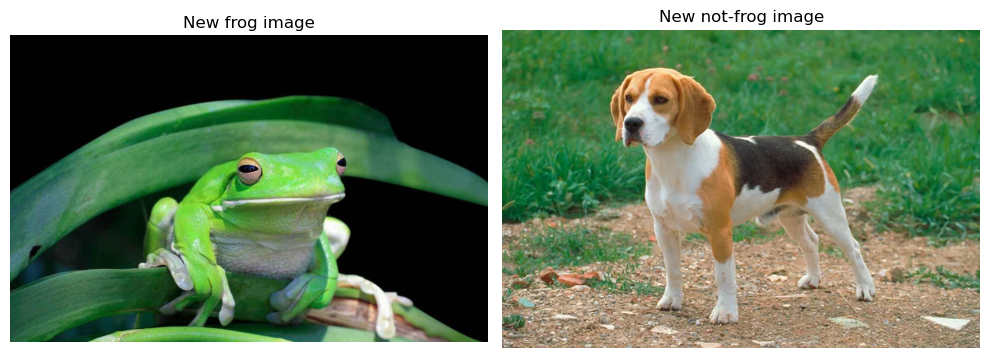

In [30]:
# Present new image

# New frog image
frog_image = Image.open("new_frog_picture.jpg")
# New non-forg image 
not_frog_image = Image.open("new_dog_picture.jpg")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the frog image
axes[0].imshow(frog_image)
axes[0].set_title("New frog image")
axes[0].axis("off")

# Show the non-forg image
axes[1].imshow(not_frog_image)
axes[1].set_title("New not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Here we presenting the images of a frog and a non-frog so we can compare. 

In [31]:
# Transforms
# Transform for changing the image into a 32x32 and normalizing
new_transform = v2.Compose([
    # Resize to 32x32
    v2.Resize((32, 32)),
    # Convert to tensor            
    v2.ToTensor(),
    # Rescale                 
    v2.Normalize((0.5, 0.5, 0.5),     
                         (0.5, 0.5, 0.5))
])

# Unnormalize for display
unnormalize = v2.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

# (Torch Contributors, 2017)

In [32]:
# Present image to be processed

# Apply transform
transformed_frog_image = new_transform(frog_image)
transformed_not_frog_image = new_transform(not_frog_image)


transformed_frog_image = unnormalize(transformed_frog_image)
transformed_not_frog_image = unnormalize(transformed_not_frog_image)

# Convert to (H, W, C) and clip for valid pixel range
display_image_forg = transformed_frog_image.permute(1, 2, 0).numpy()
display_image_not_forg = transformed_not_frog_image.permute(1, 2, 0).numpy()

# Clip intervals outside of normalisation range
display_image_forg = np.clip(display_image_forg, 0, 1)
display_image_not_forg = np.clip(display_image_not_forg, 0, 1)

## Present image to be processed 

When we reverse the normalization, we bring the pixel values back to the [0, 1] range. This is important for displaying the images with tools that expect pixel values in that range.

This handles both the technical requirements of PyTorch and the formatting needs for visual inspection, which is helpful when visualizing training data.

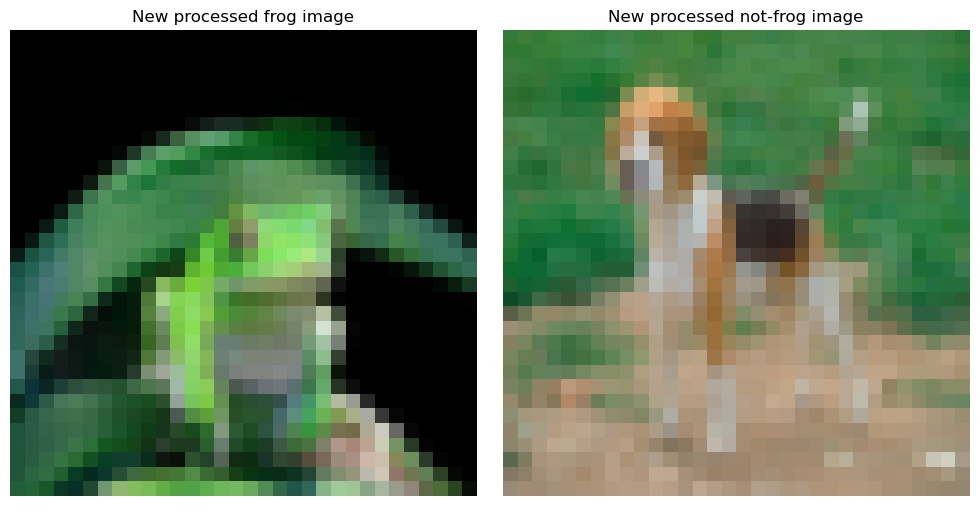

In [33]:
# Display preprocessed images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(display_image_forg)
axes[0].set_title("New processed frog image")
axes[0].axis("off")


axes[1].imshow(display_image_not_forg)
axes[1].set_title("New processed not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [34]:
# Load in model
model = FrogClassifier()
# Load in the model
model.load_state_dict(torch.load("./best_model.pth"))
model.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [35]:
images = [frog_image, not_frog_image]
# Predicted labels
labels = []

# Make prediction
for img in images:
    # Preprocess image
    processed_img = new_transform(img).unsqueeze(0)
    
    with torch.no_grad():
        
        output = model(processed_img)

        # Prediction
        prediction = torch.argmax(output, dim=1).item()

        # Confidence
        probability = torch.softmax(output, dim=1)
        confidence = probability[0][prediction].item()

        label = f"{'Frog' if prediction == 1 else 'Non-Frog'} ({confidence:.2%})"
        labels.append(label)

# (Pytorch, 2024)

## Make prediction 

This loop handles the inference step, where each image is passed through the model to get a class prediction and its associated confidence. The loop ensures that the image is transformed consistently with the training data, adds a batch dimension, disables gradient tracking for efficiency during inference, converts the raw model output into probabilities, and fetches the probability score of the predicted class. This creates a readable label, combining the predicted class name and its confidence as a percentage.

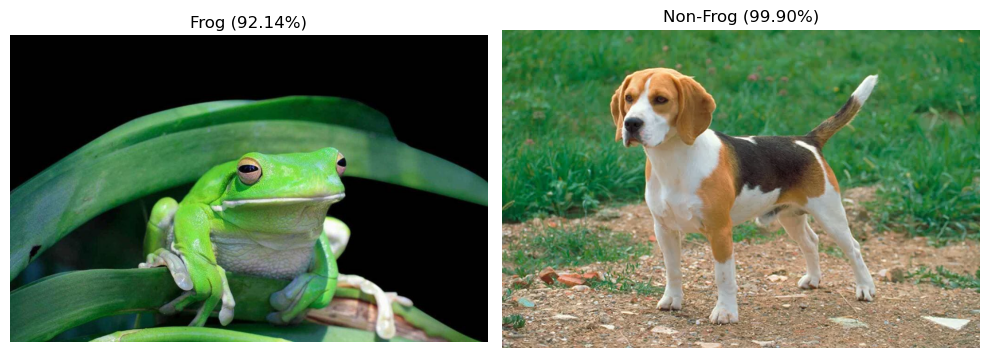

In [36]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

Our model achieves very strong results, with 92.14% confidence on the new frog image and 99.9% confidence on the new non-frog image. This shows that our model performed very well when presented with photos not included in its training data. However, this is only one image, and further testing with different frog images would provide a better understanding of our model's effectiveness as a frog classifier.

## Sources Task I

Edward Loper, Steven, Bird, & Klein, E. (2024, August 19). *Natural Language Toolkit.* Retrieved from nltk.org: https://www.nltk.org/

GeeksforGeeks. (2024, January 2). *Python | Lemmatization with Python.* Retrieved from geeksforgeeks.org: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

Google. (n.d.). *Google Colab.* Retrieved from colab.research: https://colab.research.google.com/

Krishna-Noutiyal. (2025, December 7). *Hotel-Review-Sentiment-Analysis.* Retrieved from github.com: https://github.com/Krishna-Noutiyal/Hotel-Review-Sentiment-Analysis

Ksunden. (2025, February 14). *Matplotlib.* Retrieved from Github: https://github.com/matplotlib/matplotlib/tree/v3.10.1/lib/matplotlib

Marsja, E. (2023, September 25). *Seaborn Confusion Matrix: How to Plot and Visualize in Python.* Retrieved from marsja.se: https://www.marsja.se/seaborn-confusion-matrix-how-to-plot-and-visualize-in-python/

Pandas Development Team. (2024). *Pandas.DataFrame.hist.* Retrieved from pandas.pydata.org: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

Raschka, S. (2023). *plot_learning_curves: Plot learning curves from training and test sets.* Retrieved from rasbt.github.io: https://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/?utm_source=chatgpt.com

Shaik, J. (2020, October 15). *HotelReviews Sentiment Analysis From Scratch To Deployment With Both Machine Learning And Deep Learning Algorithms.* Retrieved from medium.com: https://medium.com/analytics-vidhya/hotel-reviews-sentiment-analysis-from-scratch-to-deployment-with-both-machine-learning-and-deep-76ba89b14a56

Spectre. (2022, January 27). *How to set vocabulary size, padding length and embedding dimension in LSTM network?* Retrieved from https://datascience.stackexchange.com/: https://datascience.stackexchange.com/questions/107509/how-to-set-vocabulary-size-padding-length-and-embedding-dimension-in-lstm-netwo?utm_source=chatgpt.com

The Matplotlib development team. (2025). *The histogram (hist) function with multiple data sets.* Retrieved from matplotlib.org: https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html

Yandle. (2021, June 18). *Question about input_dim in keras embedding layer.* Retrieved from stackoverflow.com: https://stackoverflow.com/questions/68030460/question-about-input-dim-in-keras-embedding-layer?utm_source=chatgpt.com

Spiering, B. (2021, July 9). *Decision trees and Curse of Dimensionality.* Retrieved from datascience.stackexchange.com: https://datascience.stackexchange.com/questions/31802/decision-trees-and-curse-of-dimensionality#:~:text=Since%20decision%20trees%20are%20greedy%2C%20they%20are%20one,Decision%20trees%20learn%20to%20ignore%20less%20informative%20dimensions.

Ashafaque, Z. (2023, August 10). *Sentiment Analysis with Naive Bayes Algorithm.* Retrieved from medium.com: https://medium.com/@zubairashfaque/sentiment-analysis-with-naive-bayes-algorithm-a31021764fb4

Calzone, O. (2022, February 21). *An Intuitive Explanation of LSTM.* Retrieved from medium.com: https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c

Nirajan, A. (2023, July 3). *Sentimental Analysis using Logistic regression.* Retrieved from medium.com: https://medium.com/@nirajan.acharya777/sentimental-analysis-using-linear-regression-86764bfde907

## Sources Task II
PyTorch. (2017). *Training a Classifier*. pytorch.org. 
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Nekouei, F. (2023). *CIFAR-10 Image Classification* with CNN. 
    https://www.kaggle.com/.

PyTorch. (2024). *Datasets & DataLoaders*. pytorch.org.
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

PyTorch. (2024, desember 20). *Training a Classifier* . Retrieved from pytorch.org: 
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Nekouei, F. (2023). *CIFAR-10 Image Classification with CNN*. Retrieved from kaggle.com: 
    https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn

PyTorch. (2025, January 16). *Datasets & DataLoaders*. Retrieved from pytorch.org: 
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Ruman. (2023, November 6). *Ultimate Guide to Fine-Tuning in PyTorch* : Part 3 —Deep Dive to PyTorch Data Transforms with Examples. Retrieved from Medium.com: 
    https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde

Ingole, M. (2024, Juni 16). *Simple Convolutional Neural Network (CNN) for Dummies in PyTorch: A Step-by-Step Guide*. Retrieved from Medium.com:      https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80

Contributors, P. (2025). AdamW. *Retrieved from pytorch.org*: 
    https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

Contributors, P. (2024). *CrossEntropyLoss*. Retrieved from https://pytorch.org/: 
    https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

lightning.ai. (u.d.). *Early Stopping*. Retrieved from lightning.ai: 
    https://lightning.ai/docs/pytorch/stable/common/early_stopping.html

w3schools.com. (u.d.). Retrieved from 
    https://www.w3schools.com/python/matplotlib_plotting.asp

Koehrsen, W. (2018). *cifar10_cnn_exercise.ipynb*. Retrieved from 
    https://github.com/WillKoehrsen/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_exercise.ipynb

developers, s.-l. (2025). *confusion_matrix*. Retrieved from scikit-learn.org: 
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Olu-Ipinlaye, O. (2024 , October 10). *Training, Validation and Accuracy in PyTorch*. Retrieved from 
    https://www.digitalocean.com/: https://www.digitalocean.com/community/tutorials/training-validation-and-accuracy-in-pytorch

Hunter, J., Dale, D., Firing, E., & Droettboom, M. (2012). *Image tutorial*. Retrieved from matplotlib.org: 
    https://matplotlib.org/stable/tutorials/images.html

Hallaj, P. (2023, September 20). Data Augmentation: Benefits and Disadvantages. Hentet fra Medium.com: 
    https://medium.com/@pouyahallaj/data-augmentation-benefits-and-disadvantages-38d8201aead